In [2]:
pip install tushare

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.5/255.5 kB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 0.58.0
    Uninstalling websocket-client-0.58.0:
      Successfully uninstalled websocket-client-0.58.0
Note: you may need to restart the kernel to use updated packages.


In [10]:
import tushare as ts
import pandas as pd
import numpy as np

pro = ts.pro_api("20240502164019-2906dd0b-8057-4bcc-9c75-34764ede93ad")
pro._DataApi__http_url = 'http://tsapi.majors.ltd:7000'

In [ ]:
import time
from tqdm import tqdm
from time import sleep
r_total_data = pd.DataFrame()
r_etf_opt_spec = pd.DataFrame()
r_etf_spec_index = pd.DataFrame()
r_shibor = pd.DataFrame()

for i in tqdm( range(etf_opt_filtered.shape[0]) ):
    ts_code = etf_opt_filtered['ts_code'].iloc[i]
    start_date = etf_opt_filtered['list_date'].iloc[i]
   
    end_date = pd.to_datetime(etf_opt_filtered['delist_date'].iloc[i], format='%Y%m%d')-timedelta(days=1)
    end_date = end_date.strftime("%Y%m%d")
    r_etf_opt_spec = pro.opt_daily(ts_code= ts_code,start_date=start_date,end_date=end_date,fields='ts_code,trade_date,close,vol')
    r_etf_opt_spec.rename(columns = {'close':'opt_close'},inplace = True)

    r_etf_spec_index = pro.fund_daily(ts_code='510050.SH',start_date=start_date,end_date=end_date, fields='ts_code,trade_date,close')
    r_etf_spec_index.rename(columns = {'close':'etf_close'},inplace = True)

    r_shibor = pro.shibor(start_date=start_date,end_date=end_date, fields='date,on,1w,2w,1m,3m,6m,9m,1y' )
    r_shibor.rename(columns = {'date':'r_date'},inplace = True)
    r_shibor.rename(columns = {'on':'1day'},inplace = True)
    
    new = pd.concat([r_etf_opt_spec,r_etf_spec_index,r_shibor],axis=1)

    marturity_date = etf_opt_filtered['maturity_date'].iloc[i]
    exercise_price = etf_opt_filtered['exercise_price'].iloc[i]

    
    len_new = new.shape[0]
    new_ts = [ts_code] * len_new
    new_md = [marturity_date] * len_new
    new_ep = [exercise_price] * len_new

    new['ts_code'] = new_ts
    new['exer_price'] = new_ep
    new['martur_date'] = new_md

    r_total_data = pd.concat([r_total_data,new],axis=0)
    
    time.sleep(12)
    sleep(0.1)

# r_total_data.to_excel('SH50etf_r_opt_total_data.xlsx', index= True, engine='openpyxl') 

100%|█████████████████████████████████████████| 272/272 [57:36<00:00, 12.71s/it]


In [ ]:

r_list_trade_date = r_total_data.iloc[:,1]
r_total_data1 = r_total_data.drop('trade_date', axis=1)

r_total_data1 = pd.concat([r_total_data1, r_list_trade_date ], axis = 1)

r_total_data1['trade_date'] = pd.to_datetime(r_total_data1['trade_date'], format='%Y%m%d')

r_total_data1['time_to_matur'] = (r_total_data1['martur_date'] - r_total_data1['trade_date']  ).dt.days

r_total_data1 = r_total_data1[(r_total_data1.vol > 0)] 

In [412]:
r_shibor_data = r_total_data1[['1day','1w','2w','1m','3m','6m','9m','1y','time_to_matur' ]].copy()
print(r_shibor_data)

     1day     1w     2w     1m     3m     6m     9m     1y  time_to_matur
0   1.976  2.168  2.452  2.578  2.689  2.826  2.988  3.094            1.0
1   2.052  2.163  2.469  2.576  2.694  2.832  2.993  3.097            2.0
2   2.135  2.199  2.297  2.577  2.698  2.836  2.995  3.100            5.0
3   2.206  2.197  2.313  2.574  2.703  2.831  2.993  3.100            6.0
4   1.968  2.167  2.170  2.570  2.704  2.832  2.999  3.100            7.0
..    ...    ...    ...    ...    ...    ...    ...    ...            ...
17  1.618  1.795  2.064  2.302  2.503  2.530  2.545  2.565           26.0
18  1.858  2.166  2.836  2.297  2.493  2.527  2.544  2.564           27.0
19  1.608  2.076  2.815  2.279  2.481  2.525  2.544  2.564           28.0
20  1.711  2.051  2.759  2.267  2.465  2.524  2.544  2.564           29.0
21  1.809  2.094  2.699  2.255  2.463  2.523  2.543  2.563           30.0

[29521 rows x 9 columns]


In [ ]:

conditions = [
    (r_shibor_data['time_to_matur'] == 1),
    (r_shibor_data['time_to_matur'] > 1) & (r_shibor_data['time_to_matur'] <= 7),
    (r_shibor_data['time_to_matur'] > 7) & (r_shibor_data['time_to_matur'] <= 14),
    (r_shibor_data['time_to_matur'] > 14) & (r_shibor_data['time_to_matur'] <= 31),
    (r_shibor_data['time_to_matur'] > 31) & (r_shibor_data['time_to_matur'] <= 91),
    (r_shibor_data['time_to_matur'] > 91) & (r_shibor_data['time_to_matur'] <= 181),
    (r_shibor_data['time_to_matur'] > 181) & (r_shibor_data['time_to_matur'] <= 271),
    (r_shibor_data['time_to_matur'] > 271) & (r_shibor_data['time_to_matur'] <= 365)
]

choices = [
    r_shibor_data['1day'],
    r_shibor_data['1w'],
    r_shibor_data['2w'],
    r_shibor_data['1m'],
    r_shibor_data['3m'],
    r_shibor_data['6m'],
    r_shibor_data['9m'],
    r_shibor_data['1y']
]

r_shibor_data.loc[:, 'ttm_shibor'] = np.select(conditions, choices, default='Unknown')

print(r_shibor_data)

     1day     1w     2w     1m     3m     6m     9m     1y  time_to_matur  \
0   1.976  2.168  2.452  2.578  2.689  2.826  2.988  3.094            1.0   
1   2.052  2.163  2.469  2.576  2.694  2.832  2.993  3.097            2.0   
2   2.135  2.199  2.297  2.577  2.698  2.836  2.995  3.100            5.0   
3   2.206  2.197  2.313  2.574  2.703  2.831  2.993  3.100            6.0   
4   1.968  2.167  2.170  2.570  2.704  2.832  2.999  3.100            7.0   
..    ...    ...    ...    ...    ...    ...    ...    ...            ...   
17  1.618  1.795  2.064  2.302  2.503  2.530  2.545  2.565           26.0   
18  1.858  2.166  2.836  2.297  2.493  2.527  2.544  2.564           27.0   
19  1.608  2.076  2.815  2.279  2.481  2.525  2.544  2.564           28.0   
20  1.711  2.051  2.759  2.267  2.465  2.524  2.544  2.564           29.0   
21  1.809  2.094  2.699  2.255  2.463  2.523  2.543  2.563           30.0   

   ttm_shibor  
0       1.976  
1       2.163  
2       2.199  
3       2.1

In [ ]:
r_total_data1['ttm_shibor'] = r_shibor_data['ttm_shibor']
print(r_total_data1)
r_total_data1.to_excel('r_total_data1.xlsx', index= True, engine='openpyxl') 

r_total_data2 = r_total_data1[( (r_total_data1.etf_close/ r_total_data1.exer_price> 0.97) & (r_total_data1.etf_close/ r_total_data1.exer_price <1.03)  )] 
print(r_total_data2)


        ts_code  opt_close       vol      ts_code  etf_close    r_date   1day  \
0   10003257.SH     0.0001    2133.0  10003257.SH      3.504  20210323  1.976   
1   10003257.SH     0.0001    3758.0  10003257.SH      3.523  20210322  2.052   
2   10003257.SH     0.0001   15986.0  10003257.SH      3.496  20210319  2.135   
3   10003257.SH     0.0002    1098.0  10003257.SH      3.591  20210318  2.206   
4   10003257.SH     0.0002    2228.0  10003257.SH      3.576  20210317  1.968   
..          ...        ...       ...          ...        ...       ...    ...   
17  10006369.SH     0.0169  101246.0  10006369.SH      2.385  20231201  1.618   
18  10006369.SH     0.0220   86344.0  10006369.SH      2.401  20231130  1.858   
19  10006369.SH     0.0211   89322.0  10006369.SH      2.395  20231129  1.608   
20  10006369.SH     0.0262   61150.0  10006369.SH      2.406  20231128  1.711   
21  10006369.SH     0.0259   84907.0  10006369.SH      2.407  20231127  1.809   

       1w     2w     1m    

In [400]:
print(r_total_data1)

        ts_code  opt_close       vol      ts_code  etf_close    r_date   1day  \
0   10003257.SH     0.0001    2133.0  10003257.SH      3.504  20210323  1.976   
1   10003257.SH     0.0001    3758.0  10003257.SH      3.523  20210322  2.052   
2   10003257.SH     0.0001   15986.0  10003257.SH      3.496  20210319  2.135   
3   10003257.SH     0.0002    1098.0  10003257.SH      3.591  20210318  2.206   
4   10003257.SH     0.0002    2228.0  10003257.SH      3.576  20210317  1.968   
..          ...        ...       ...          ...        ...       ...    ...   
17  10006369.SH     0.0169  101246.0  10006369.SH      2.385  20231201  1.618   
18  10006369.SH     0.0220   86344.0  10006369.SH      2.401  20231130  1.858   
19  10006369.SH     0.0211   89322.0  10006369.SH      2.395  20231129  1.608   
20  10006369.SH     0.0262   61150.0  10006369.SH      2.406  20231128  1.711   
21  10006369.SH     0.0259   84907.0  10006369.SH      2.407  20231127  1.809   

       1w     2w     1m    

In [ ]:
dff_pap = r_total_data2
date_counts = dff_pap['martur_date'].value_counts()
print(date_counts )

result_pap_sto = pd.DataFrame(columns=['date', 'mean_call_price', 'mean_under_price', 'volume'])

for date in dff_pap['martur_date'].unique():
    mean_call_price = dff_pap[dff_pap['martur_date'] == date]['opt_close'].mean()
    mean_under_price = dff_pap[dff_pap['martur_date'] == date]['etf_close'].mean()
    volume = date_counts[date]
    
    result_pap_sto = result_pap_sto.append({'date': date,
                                  'mean_call_price': mean_call_price,
                                  'mean_under_price': mean_under_price,
                                  'volume': volume}, 
                                 ignore_index=True)

print("新 DataFrame:")
print(result_pap_sto)

2023-06-28    944
2023-03-22    749
2022-06-22    651
2022-12-28    579
2023-12-27    568
2023-09-27    533
2022-09-28    513
2022-03-23    482
2021-12-22    353
2021-09-22    332
2021-03-24      3
2021-06-23      3
Name: martur_date, dtype: int64
新 DataFrame:
         date  mean_call_price  mean_under_price volume
0  2021-03-24         0.071167          4.005667      3
1  2021-06-23         0.166267          4.005667      3
2  2021-09-22         0.159227          3.488696    332
3  2021-12-22         0.117609          3.336286    353
4  2022-03-23         0.112738          3.156064    482
5  2022-06-22         0.129696          3.000026    651
6  2022-09-28         0.133671          2.848179    513
7  2022-12-28         0.109838          2.722136    579
8  2023-03-22         0.106677          2.701016    749
9  2023-06-28         0.115850          2.663347    944
10 2023-09-27         0.115243          2.649266    533
11 2023-12-27         0.083715          2.529246    568


/var/folders/l_/c_zc37bn33bcc1l7_b8v2z800000gn/T/ipykernel_92952/3888203003.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_pap_sto = result_pap_sto.append({'date': date,
/var/folders/l_/c_zc37bn33bcc1l7_b8v2z800000gn/T/ipykernel_92952/3888203003.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_pap_sto = result_pap_sto.append({'date': date,
/var/folders/l_/c_zc37bn33bcc1l7_b8v2z800000gn/T/ipykernel_92952/3888203003.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_pap_sto = result_pap_sto.append({'date': date,
/var/folders/l_/c_zc37bn33bcc1l7_b8v2z800000gn/T/ipykernel_92952/3888203003.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

$ I(m, \sigma; a, a_1, a_2) = \frac{1}{\sigma \sqrt{2\pi}} \int_{0}^{\infty} e^{au}\Phi(a_1+a_2u)e^{-\frac{(u-m)^2}{2\sigma^2}}du$
$ = e^{\frac{1}{2} (a^2\sigma^2 + 2am)} [ \frac{\Phi(h_1) - \Phi(h_2)}{2} - T(h_1, \bar{a}_1) - T(h_2,\bar{a}_2)   ]$\\

$h_1 = \frac{a_1 + a_2(m+a\sigma^2)}{\sqrt{1+a_2^2 \sigma^2} },  h_2 = \frac{-m-a\sigma^2}{\sigma},  \bar{a}_1 = \frac{h_2- rh_1}{h_1\sqrt{1-r^2}},  \bar{a}_2 = \frac{h_1-rh_2}{h_2\sqrt{1-r^2}},  r = \frac{-a_2\sigma}{\sqrt{1+a_2^2\sigma^2}}$

In [ ]:
from scipy import integrate
from scipy import special
from scipy.integrate import quad 
import scipy.stats as st
#CDF st.norm.cdf(0)
import numpy as np

def Iowenfun(m, sigma, a, a1, a2):

    h1 = (a1 + a2 * (m + a * sigma**2)) / np.sqrt(1 + a2**2 * sigma**2)
    h2 = (-m - a * sigma**2) / sigma
    Ir = -a2 * sigma / np.sqrt(1 + a2**2 * sigma**2)
    bar_a1 = (h2 - Ir * h1) / (h1 * np.sqrt(1 - Ir**2))
    bar_a2 = (h1 - Ir * h2) / (h2 * np.sqrt(1 - Ir**2))

    exp_component = np.exp(0.5 * (a**2 * sigma**2 + 2 * a * m))
    phi_diff = (st.norm.cdf(h1) - st.norm.cdf(h2)) / 2
    
    T_term = special.owens_t(h1, bar_a1) + special.owens_t(h2, bar_a2)
    
    I_value = exp_component * (phi_diff - T_term)
    
    return I_value


def f(u, m, sigma, a, a1, a2):
    return st.norm.cdf( a1 + a2*u )*np.exp( a*u - (u-m)**2/(2*sigma**2) )


def I1(m, sigma, a, a1, a2):
    v, err = integrate.quad(f, 0, np.inf , args = (m, sigma, a, a1, a2) )
    
    I_value = v/(sigma*np.sqrt(2*np.pi))
    
    return I_value


$l = log( 2\Phi(\sigma \delta \sqrt{T-t} )   )$

$D(t) = S(t)e^{(r-0.5*\sigma^2)(T-t) - l + 0.5\sigma^2(1-\delta^2)(T-t)}$

$a_1 = [-\sigma^2\delta^2(T-t) - log(K/S(t)) + (r+0.5\sigma^2)(T-t) - l  ]/(\sigma \sqrt{(1-\delta^2)(T-t)}) $

$a_2 = (- log(K/S(t)) + (r-0.5\sigma^2)(T-t) - l    )/(\sigma \sqrt{(1-\delta^2)(T-t)}) $

$V(S(t),K,r,\sigma,\delta,T-t) = 2D(t)I(0,\sqrt{T-t},\sigma \delta,a_1,\frac{\delta}{\sqrt{(1-\delta^2)(T-t)}}) - KI(0,\sqrt{T-t},0,a_2,\frac{\delta}{\sqrt{(1-\delta^2)(T-t)}})    $


In [ ]:
def V(St, K, r, sigma, delta, T_minus_t):

    sigma_delta_sqrt = sigma * delta * np.sqrt(T_minus_t)
    l = np.log(2 * st.norm.cdf(sigma_delta_sqrt))
    

    D_t = St * np.exp( (r - 0.5 * sigma**2) * (T_minus_t) - l + 0.5 * sigma**2 * (1-delta**2) * (T_minus_t) )
    

    a1 = (-sigma**2 * delta**2 * T_minus_t - np.log(K / St) + (r + 0.5 * sigma**2) * T_minus_t - l) / (sigma * np.sqrt((1 - delta**2) * T_minus_t))

    a2 = (-np.log(K / St) + (r - 0.5 * sigma**2) * T_minus_t - l) / (sigma * np.sqrt((1 - delta**2) * T_minus_t))

    term1 = 2 * D_t * I1(0, np.sqrt(T_minus_t), sigma * delta, a1, delta / np.sqrt((1 - delta**2) * T_minus_t))

    term2 = 2 * I1(0, np.sqrt(T_minus_t), 0, a2, delta / np.sqrt((1 - delta**2) * T_minus_t))

    V_value = (term1 - K*term2)*np.exp(-r* T_minus_t)
    return V_value


In [ ]:
import numpy as np
import random
import math
import copy
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

def initial(pop, dim, ub, lb):
    X = np.zeros([pop, dim])
    for i in range(pop):
        for j in range(dim):
            X[i, j] = random.random()*(ub[j] - lb[j]) + lb[j]
    
    return X,lb,ub
            

def BorderCheck(X,ub,lb,pop,dim):
    for i in range(pop):
        for j in range(dim):
            if X[i,j]>ub[j]:
                X[i,j] = ub[j]
            elif X[i,j]<lb[j]:
                X[i,j] = lb[j]
    return X
    

def CaculateFitness(X,fun):
    pop = X.shape[0]
    fitness = np.zeros([pop, 1])
    for i in range(pop):
        fitness[i] = fun(X[i, :]) 
    return fitness


def SortFitness(Fit):
    fitness = np.sort(Fit, axis=0)
    index = np.argsort(Fit, axis=0)
    return fitness,index



def SortPosition(X,index):
    Xnew = np.zeros(X.shape)
    for i in range(X.shape[0]):
        Xnew[i,:] = X[index[i],:]
    return Xnew


def Levy(d):
    beta = 3/2
    sigma = (math.gamma(1 + beta)*np.sin(math.pi*beta/2))/(math.gamma((1 + beta)/2)*beta*2**((beta-1)/2))**(1/beta)
    u = np.random.randn(1,d)*sigma
    v = np.random.randn(1,d)
    step = u/np.abs(v)**(1/beta)
    L = 0.05*step
    return L


def MPA(pop,dim,lb,ub,MaxIter,fun):
    P=0.5
    FADS = 0.2
    X,lb,ub = initial(pop, dim, ub, lb) 
    fitness = CaculateFitness(X,fun) 
    fitness,sortIndex = SortFitness(fitness) 
    X = SortPosition(X,sortIndex) 
    GbestScore = copy.copy(fitness[0])
    GbestPositon = np.zeros([1,dim])
    GbestPositon[0,:] = copy.copy(X[0,:])
    Curve = np.zeros([MaxIter,1])
    Xnew = copy.copy(X)
    for t in tqdm(range(MaxIter)):

        sleep(0.0000000000001)

        RB = np.random.randn(pop,dim)
        L = Levy(dim)
        CF = (1 - t/MaxIter)**(2*t/MaxIter)
        for i in range(pop):
            for j in range(dim):
                if t<MaxIter/3:
                    stepSize = RB[i,j]*(GbestPositon[0,j] - RB[i,j]*X[i,j])
                    Xnew[i,j] = X[i,j] + P*np.random.random()*stepSize
                if t>=MaxIter/3 and t<=2*MaxIter/3: 
                    if i<pop/2:
                        stepSize = L[0,j]*(GbestPositon[0,j] - L[0,j]*X[i,j])
                        Xnew[i,j] = X[i,j] + P*np.random.random()*stepSize
                    else:
                        stepSize = RB[i,j]*( RB[i,j]*GbestPositon[0,j] -X[i,j])
                        Xnew[i,j] = X[i,j] + P*CF*stepSize
                if t>2*MaxIter/3: 
                    stepSize = L[0,j]*(L[0,j]*GbestPositon[0,j] - X[i,j])
                    Xnew[i,j] = X[i,j] + P*CF*stepSize
        
        Xnew=BorderCheck(Xnew,ub,lb,pop,dim)
        fitnessNew = CaculateFitness(Xnew,fun) 
        for i in range(pop):
            if fitnessNew[i]<fitness[i]:
                fitness[i] = copy.copy(fitnessNew[i])
                X[i,:] = copy.copy(Xnew[i,:])
        
        indexBest = np.argmin(fitness)
        if(fitness[indexBest]<GbestScore):
            GbestScore = copy.copy(fitness[indexBest])
            GbestPositon[0,:] = copy.copy(X[indexBest,:])
        
       
        for i in range(pop):
            for j in range(dim):
                if np.random.random()<FADS:
                    U = np.random.random()<FADS
                    Xnew[i,j] = X[i,j]*CF*(lb[j,0] + np.random.random()*(ub[j,0]-lb[j,0])*U)
                else:
                    r = np.random.random()
                    stepsize=(FADS*(1-r)+r)*(X[np.random.randint(pop),j]-X[np.random.randint(pop),j])
                    Xnew[i,j] = X[i,j] + stepsize
        Xnew=BorderCheck(Xnew,ub,lb,pop,dim)
        fitnessNew = CaculateFitness(Xnew,fun)
        for i in range(pop):
            if fitnessNew[i]<fitness[i]:
                fitness[i] = fitnessNew[i].item()
                X[i,:] = copy.copy(Xnew[i,:])
        
        indexBest = np.argmin(fitness)
        if(fitness[indexBest]<GbestScore): 
            GbestScore = copy.copy(fitness[indexBest])
            GbestPositon[0,:] = copy.copy(X[indexBest,:])
    
            
        Curve[t] = GbestScore
    
    return GbestScore,GbestPositon,Curve



  0%|                                                    | 0/30 [00:00<?, ?it/s]/var/folders/l_/c_zc37bn33bcc1l7_b8v2z800000gn/T/ipykernel_92952/293591656.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  a1 = (-sigma**2 * delta**2 * T_minus_t - np.log(K / St) + (r + 0.5 * sigma**2) * T_minus_t - l) / (sigma * np.sqrt((1 - delta**2) * T_minus_t))
/var/folders/l_/c_zc37bn33bcc1l7_b8v2z800000gn/T/ipykernel_92952/293591656.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  a2 = (-np.log(K / St) + (r - 0.5 * sigma**2) * T_minus_t - l) / (sigma * np.sqrt((1 - delta**2) * T_minus_t))
  3%|█▎                                      | 1/30 [16:48<8:07:35, 1008.79s/it]/var/folders/l_/c_zc37bn33bcc1l7_b8v2z800000gn/T/ipykernel_92952/293591656.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  term1 = 2 * D_t * I1(0, np.sqrt(T_minus_t), sigma * delta, a1, delta / np.sqrt((1 - delta**2) * T_minus_t))
/var/folders/l_/c_zc37bn33bcc1l7_b8v2z80000

最优适应度值： [0.01528745]
最优解： [[0.22446985 0.75782697]]


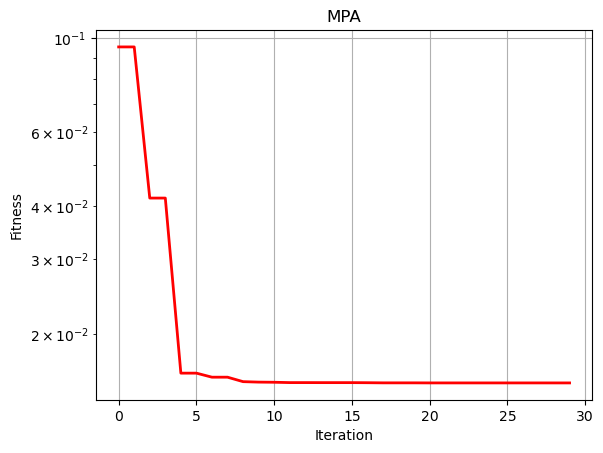

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial


fun_data = r_total_data2

def fun_rmse(X, fun_data):
    X = X.flatten()
    St = fun_data['etf_close'].to_numpy()
    K = fun_data['exer_price'].to_numpy()
    r = fun_data['ttm_shibor'].astype(float).to_numpy()/100
    sigma = np.full( (fun_data.shape[0],1), X[0] ).flatten()
    delta = np.full( (fun_data.shape[0],1), X[1] ).flatten()
    T_minus_t = fun_data['time_to_matur'].astype(float).to_numpy()/365
    real_price = fun_data['opt_close'].to_numpy()
    formula_price = np.zeros((fun_data.shape[0],1)).flatten()

    for dd in range(fun_data.shape[0]) :

        formula_price[dd] = V(St[dd], K[dd], r[dd], sigma[dd], delta[dd], T_minus_t[dd])

    nan_mask = np.isnan(formula_price)
    real_price1 = real_price[~nan_mask ].flatten()
    formula_price1 = formula_price[~nan_mask ].flatten()
    formula_rmse = np.sqrt( np.mean( (formula_price - real_price)**2   )  )

    return formula_rmse


'''主函数 '''

pop = 15
MaxIter = 30 
dim = 2 

lb = np.zeros([dim, 1]) 
lb[1,:] = -1
ub = 10*np.ones([dim, 1])
ub[1,:] = 1

fobj = partial(fun_rmse, fun_data = fun_data)
GbestScore,GbestPositon,Curve = MPA(pop,dim,lb,ub,MaxIter,fobj) 
print('最优适应度值：',GbestScore)
print('最优解：',GbestPositon)

plt.figure(1)
plt.semilogy(Curve,'r-',linewidth=2)
plt.xlabel('Iteration',fontsize='medium')
plt.ylabel("Fitness",fontsize='medium')
plt.grid()
plt.title('MPA',fontsize='large')
plt.show()

